In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/donnes-du-pnkb/Donnes du PNKB.csv


In [2]:
# Step 1: Import Libraries and Check Dataset Directory
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# Set the dataset directory based on your file path
dataset_dir = '/kaggle/input/donnes-du-pnkb'
print("Files in dataset directory:", os.listdir(dataset_dir))

Files in dataset directory: ['Donnes du PNKB.csv']


The first step is to import libraries

In [3]:
# Step 2: Load the CSV File using the correct separator (semicolon)
csv_file = os.path.join(dataset_dir, 'Donnes du PNKB.csv')
data = pd.read_csv(csv_file, sep=';', on_bad_lines='skip', encoding='utf-8')
print("First few rows of the raw data:")
print(data.head())


First few rows of the raw data:
  METHODES    Genre     EPITHETE CIRCONFERENCE EN CM DIAMETRE EN CM  \
0       P1  Agauria  salicifolia                  34    10,82802548   
1       P1  Agauria  salicifolia                  31    9,872611465   
2       P1  Agauria  salicifolia                  39    12,42038217   
3       P1  Agauria  salicifolia                  39    12,42038217   
4       P1  Agauria  salicifolia                  36    11,46496815   

   Altitude en m   groupe               espece Height volume_en_m3 BasalArea  \
0           2350  Placeau  Agauria salicifolia   6,33        57,44      0,01   
1           2350  Placeau  Agauria salicifolia   5,74         43,3      0,01   
2           2350  Placeau  Agauria salicifolia   7,26        86,68      0,01   
3           2350  Placeau  Agauria salicifolia   7,26        86,68      0,01   
4           2350  Placeau  Agauria salicifolia   6,71        68,26      0,01   

  WoodDensity Superficie_ha  
0        0,49             2  


The idea is to ensure the raw data aligns with the exact separator to limit troubles in my analysis

In [4]:
# Step 3: Clean and Rename Columns
# Trim any extra whitespace from the column names
data.columns = [col.strip() for col in data.columns]

# Rename key columns for easier access (adjust if needed)
data.rename(columns={"DIAMETRE EN CM": "diameter", "Height": "height"}, inplace=True)

# Replace comma with period in the numeric fields and convert to float.
# This conversion assumes that commas are used as the decimal separator.
data['diameter'] = data['diameter'].astype(str).str.replace(',', '.')
data['height'] = data['height'].astype(str).str.replace(',', '.')

# Convert the cleaned strings to numeric values
data['diameter'] = pd.to_numeric(data['diameter'], errors='coerce')
data['height'] = pd.to_numeric(data['height'], errors='coerce')

print("\nCleaned 'diameter' and 'height' columns:")
print(data[['diameter', 'height']].head())

# Optional: Drop rows where conversion failed (NaN values)
data.dropna(subset=['diameter', 'height'], inplace=True)



Cleaned 'diameter' and 'height' columns:
    diameter  height
0  10.828025    6.33
1   9.872611    5.74
2  12.420382    7.26
3  12.420382    7.26
4  11.464968    6.71


Cleaning and organisation of a dataset is crucial for better results


Columns in data: Index(['METHODES', 'Genre', 'EPITHETE', 'CIRCONFERENCE EN CM', 'diameter',
       'Altitude en m', 'groupe', 'espece', 'height', 'volume_en_m3',
       'BasalArea', 'WoodDensity', 'Superficie_ha'],
      dtype='object')

Data summary:
         diameter  Altitude en m      height
count  810.000000     810.000000  810.000000
mean    23.488441    2436.398765   10.087012
std     11.721924      73.226339    3.138020
min      9.554140    2350.000000    4.890000
25%     14.968153    2376.000000    7.800000
50%     20.700637    2450.000000    9.500000
75%     28.264331    2450.000000   11.565000
max     87.579618    2588.000000   21.160000


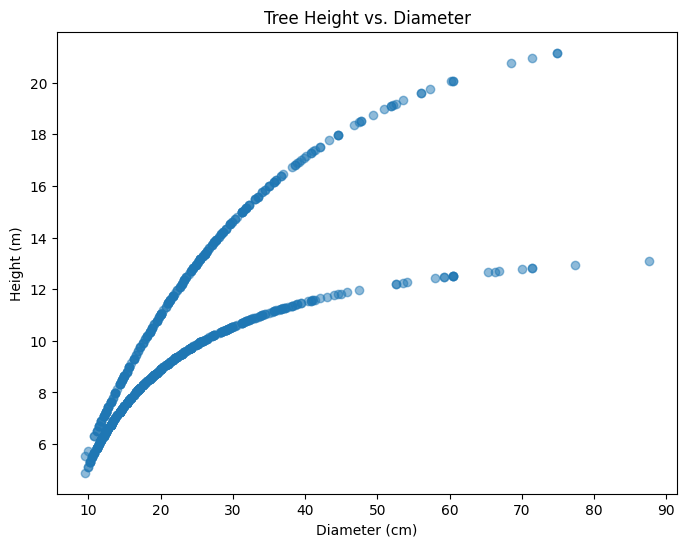

In [5]:
# Step 4: Data Exploration and Visualization
print("\nColumns in data:", data.columns)
print("\nData summary:")
print(data.describe())

# Plot tree height vs. diameter
plt.figure(figsize=(8,6))
plt.scatter(data['diameter'], data['height'], alpha=0.5)
plt.xlabel('Diameter (cm)')
plt.ylabel('Height (m)')
plt.title('Tree Height vs. Diameter')
plt.show()

Just to make sure i am on the right way. Then I can fit my model

In [ ]:
# Step 5: Fit a Height-Diameter Model (Gompertz Model Example)
def gompertz_model(D, a, b, c):
    return a * np.exp(-b * np.exp(-c * D))

# Provide an initial guess for parameters [a, b, c]
initial_guess = [max(data['height']), 1, 0.1]

# Fit the Gompertz model using non-linear least squares
popt, pcov = curve_fit(gompertz_model, data['diameter'], data['height'], p0=initial_guess)
print("\nEstimated Gompertz parameters (a, b, c):", popt)

# Generate predictions for a smooth curve
D_range = np.linspace(data['diameter'].min(), data['diameter'].max(), 100)
predicted_height = gompertz_model(D_range, *popt)

# Plot observed data and the Gompertz fit
plt.figure(figsize=(8,6))
plt.scatter(data['diameter'], data['height'], alpha=0.5, label='Observed Data')
plt.plot(D_range, predicted_height, color='red', label='Gompertz Fit')
plt.xlabel('Diameter (cm)')
plt.ylabel('Height (m)')
plt.title('Gompertz Height-Diameter Model')
plt.legend()
plt.show()


Estimated Gompertz parameters (a, b, c): [16.37711999  2.08336587  0.06829628]


In this step, we define the Gompertz function—a common non-linear model for tree growth—and use curve fitting to estimate its parameters. The model describes how tree height increases with diameter in an asymptotic way. We then generate predictions over a range of diameters to visualize how well the model fits the observed data.

In [ ]:
# Step 6: Estimate Biomass Using an Allometric Equation
# Example: Chave et al. equation (using wood density in g/cm³)
wood_density = 0.6  # Adjust as needed

def biomass_model(D, H, wd):
    return 0.0673 * (wd * (D**2) * H)**0.976

# Calculate biomass and add it as a new column
data['biomass'] = biomass_model(data['diameter'], data['height'], wood_density)
print("\nFirst few rows with biomass:")
print(data[['diameter', 'height', 'biomass']].head())


Here, we estimate the above-ground biomass of each tree using an allometric equation (inspired by Chave et al.). The equation incorporates tree diameter, height, and wood density. This provides a standardized way to convert tree measurements into biomass estimates.

In [ ]:
# Step 7: Estimate Carbon Stock (typically 50% of biomass)
data['carbon_stock'] = data['biomass'] * 0.5
print("\nFirst few rows with biomass and carbon stock:")
print(data[['biomass', 'carbon_stock']].head())

Step 7: Estimate Carbon Stock
Since carbon stock is typically assumed to be about 50% of the biomass, we calculate the carbon stock for each tree by multiplying the biomass by 0.5. This step helps translate biomass estimates into carbon storage, which is critical for understanding carbon dynamics in forest ecosystems.

In [ ]:
# Step 8: Model Evaluation (RMSE and AIC)
# Calculate predicted heights for the original data points
predicted_heights = gompertz_model(data['diameter'], *popt)
rmse = np.sqrt(mean_squared_error(data['height'], predicted_heights))
print("\nRMSE for Gompertz model:", rmse)

# Define a function to calculate AIC for the model
def calculate_aic(n, mse, num_params):
    return n * np.log(mse) + 2 * num_params

n = len(data)
mse_value = mean_squared_error(data['height'], predicted_heights)
aic = calculate_aic(n, mse_value, 3)  # 3 parameters in the Gompertz model
print("AIC for Gompertz model:", aic)

To assess the quality of our height-diameter model, we compute the Root Mean Squared Error (RMSE) between the observed tree heights and those predicted by our model. Additionally, we calculate the Akaike Information Criterion (AIC), which helps balance model fit with complexity. Lower values of RMSE and AIC indicate a better model performance.

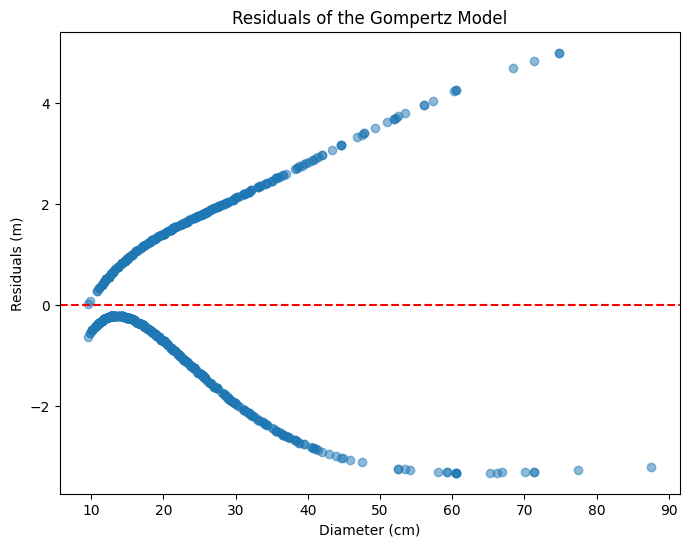

In [10]:
# Step 9: Optional - Residual Analysis
residuals = data['height'] - predicted_heights
plt.figure(figsize=(8,6))
plt.scatter(data['diameter'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Diameter (cm)')
plt.ylabel('Residuals (m)')
plt.title('Residuals of the Gompertz Model')
plt.show()

Residual analysis involves plotting the differences between observed and predicted heights. This helps check for any systematic patterns in the errors. Ideally, residuals should be randomly scattered around zero, indicating that the model captures the main trends in the data without bias.